# Text generation with an RNN

### Kevin Finity, kf2tg

Thanks to these authors that I borrowed code from!

* https://cloud.google.com/ai-platform/docs/getting-started-keras
* https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms
* https://cloud.google.com/ai-platform/prediction/docs/online-predict#python
* https://towardsdatascience.com/10-minutes-to-deploying-a-deep-learning-model-on-google-cloud-platform-13fa56a266ee

This was run locally, but would probably also work in Google Colab.

## Setup

### Import TensorFlow and other libraries

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import os
import time
from nltk import ngrams

checkpoint_dir = 'training-checkpoints/'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Download the dataset

Change the following line to run this code on your own data.

In [4]:
#path_to_file = tf.keras.utils.get_file('speeches.json', 'https://github.com/kfinity/capstone-speeches/raw/master/speeches.json')

### Read the data

First, look in the text:

In [8]:
names = pd.read_csv('names.csv', header=None)
names.columns = ['name','gender','count','year']

In [10]:
unames = names['name'].unique()
# length of text is the number of characters in it
print ('Number of names: {}'.format(len(unames)))

Number of names: 97307


In [11]:
# Take a look at the first 5 names
print(unames[:5])

['Emma' 'Olivia' 'Ava' 'Isabella' 'Sophia']


In [17]:
# The unique characters in the file
vocab = sorted(set(''.join(unames)))
print ('{} unique characters'.format(len(vocab)))

52 unique characters


## Process the text

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers, and another for numbers to characters.

In [89]:
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')

def get_sequence_of_tokens(corpus):
    ## tokenization
    tk.fit_on_texts(corpus)
    total_words = len(tk.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tk.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

vocab = tk.word_index
inp_sequences, total_words = get_sequence_of_tokens(unames)
inp_sequences[:10]


[[3, 14],
 [3, 14, 14],
 [3, 14, 14, 2],
 [11, 7],
 [11, 7, 5],
 [11, 7, 5, 20],
 [11, 7, 5, 20, 5],
 [11, 7, 5, 20, 5, 2],
 [2, 20],
 [2, 20, 2]]

In [247]:
# save tokenizer settings for later
import io
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tk.to_json(), ensure_ascii=False))

In [91]:
print(len(vocab))
print(unames[0])
print(inp_sequences[0:3])

0
Emma
[[3, 14], [3, 14, 14], [3, 14, 14, 2]]


In [93]:
# have to pad sequences to the same length

def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = tf.keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)



In [100]:
predictors.shape

(538410, 14)

In [211]:
def create_model(input_len, total_chars):
    
    model = tf.keras.models.Sequential()
    
    # Add Input Embedding Layer
    model.add(tf.keras.layers.Embedding(total_chars, 100, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(tf.keras.layers.LSTM(200))
    #model.add(tf.keras.layers.Dropout(0.1))
    
    # Add Output Layer
    model.add(tf.keras.layers.Dense(total_chars, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

input_len = max_sequence_len - 1
model = create_model(input_len, total_words)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 14, 100)           2800      
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 28)                5628      
Total params: 249,228
Trainable params: 249,228
Non-trainable params: 0
_________________________________________________________________


In [213]:
history = model.fit(predictors, label, epochs=10)

Epoch 1/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7668
Epoch 2/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7605
Epoch 3/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7555
Epoch 4/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7509
Epoch 5/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7469
Epoch 6/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7434
Epoch 7/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7397
Epoch 8/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7372
Epoch 9/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7338
Epoch 10/10
16826/16826 [==============================] - 52s 3ms/step - loss: 1.7313


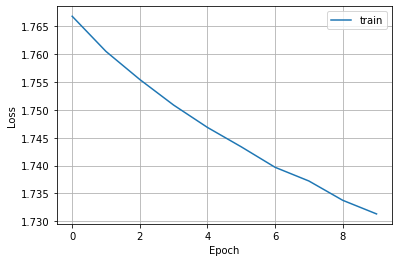

In [214]:
import matplotlib.pyplot as plt
def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    #plt.plot(history.history['val_loss'], label='validation')
    #plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [204]:
def generate_text(seed_text, model, randomness=True, temperature=0.25, max_sequence_len=15):
    
    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = temperature
    
    inv_map = {v: k for k, v in tk.word_index.items()}
    
    
    # Here batch size == 1
    model.reset_states()
    predicted_id = 1
    while predicted_id != 0: #for i in range(num_generate):
        input_eval = tk.texts_to_sequences([seed_text])[0]
        input_eval = pad_sequences([input_eval], maxlen=max_sequence_len-1, padding='pre')
        predictions = model(input_eval)
        # remove the batch dimension
        #predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        if randomness:
            predictions = predictions / temperature
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        else:
            predicted_id = np.argmax(predictions)

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        #input_eval = tf.expand_dims([predicted_id], 0)
        if predicted_id == 0:
            break # end of name
        if predicted_id == 1:
            break
        if len(seed_text) > 14:
            break

        seed_text += str(inv_map[predicted_id])

    return seed_text #(start_string + ''.join(text_generated))
    

In [209]:

generate_text('M', model, True, 0.1)

'Maricelseerpura'

In [215]:
model.save('namegen')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: namegen/assets


In [282]:
word2seq = {'UNK': 1,
     'a': 2,
     'e': 3,
     'n': 4,
     'i': 5,
     'r': 6,
     'l': 7,
     's': 8,
     'h': 9,
     'y': 10,
     'o': 11,
     't': 12,
     'd': 13,
     'm': 14,
     'k': 15,
     'c': 16,
     'u': 17,
     'j': 18,
     'b': 19,
     'v': 20,
     'z': 21,
     'g': 22,
     'w': 23,
     'p': 24,
     'f': 25,
     'q': 26,
     'x': 27}
seq2word = {v: k for k, v in word2seq.items()}

ml = discovery.build('ml', 'v1')


def get_names(names):
    temperature = 0.25
    max_len = 15
    randomness = True
    seed_text = names[-1]

    # convert to sequence
    input_eval = [word2seq[c] for c in seed_text.lower()]
    # pad to 14 items
    input_eval = [0] * (max_len-1-len(input_eval)) + input_eval
    
    request_body = { 'instances': [input_eval] }
    request = ml.projects().predict(
        name='projects/sys6016codeathon3/models/namegen/versions/v1',
        body=request_body)

    response = request.execute()
    if 'error' in response:
        # break
        print('error: ' + str(response))
        return names
    
    predictions = np.array(response['predictions'][0]['dense_3'])
    # remove the batch dimension
    #predictions = tf.squeeze(predictions, 0)

    # using a categorical distribution to predict the character returned by the model
    #if randomness:
    #    predictions = predictions / temperature
    #    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    #else:
    predicted_id = np.argmax(predictions)

    # We pass the predicted character as the next input to the model
    # along with the previous hidden state

    if predicted_id > 1 and len(seed_text) < max_len:
        seed_text += str(seq2word[predicted_id])
        names.append(seed_text)
        names = get_names(names)

    return names
    
get_names(['Ann'])

['Ann',
 'Anna',
 'Annal',
 'Annali',
 'Annalis',
 'Annalisa',
 'Annalisab',
 'Annalisabe',
 'Annalisabet',
 'Annalisabeth',
 'Annalisabetha',
 'Annalisabethan',
 'Annalisabethann']

In [273]:
word2seq = {'UNK': 1,
     'a': 2,
     'e': 3,
     'n': 4,
     'i': 5,
     'r': 6,
     'l': 7,
     's': 8,
     'h': 9,
     'y': 10,
     'o': 11,
     't': 12,
     'd': 13,
     'm': 14,
     'k': 15,
     'c': 16,
     'u': 17,
     'j': 18,
     'b': 19,
     'v': 20,
     'z': 21,
     'g': 22,
     'w': 23,
     'p': 24,
     'f': 25,
     'q': 26,
     'x': 27}
seq2word = {v: k for k, v in word2seq.items()}
max_len = 15

seq = [word2seq[c] for c in 'helloooo']
seq = [0] * (max_len-1-len(seq)) + seq
seq

[0, 0, 0, 0, 0, 0, 9, 3, 7, 7, 11, 11, 11, 11]

In [267]:
str1 = '000hello'
str2 = ''
for c in str1:
    if c in word2seq.keys():
        str2 += c
str2

'hello'

In [284]:
[s.capitalize() for s in ['hi','hello','yes']]

['Hi', 'Hello', 'Yes']

In [244]:
service = discovery.build('ml', 'v1')
name = 'projects/sys6016codeathon3/models/namegen'

#if version is not None:
#    name += '/versions/{}'.format(version)

response = service.projects().predict(
    name=name,
    body={'instances': token_list.tolist()}
).execute()

if 'error' in response:
    raise RuntimeError(response['error'])

print(response)

{'predictions': [{'dense_3': [3.1598471061933253e-10, 2.805835841446225e-10, 0.03938860073685646, 0.00758354039862752, 0.18970879912376404, 0.03228096291422844, 0.12639151513576508, 0.17454369366168976, 0.044460222125053406, 0.02167532406747341, 0.023425813764333725, 0.0014150222996249795, 0.018258733674883842, 0.07893252372741699, 0.06286615133285522, 0.019366944208741188, 0.008195511065423489, 0.02831641584634781, 0.005635043140500784, 0.04026518389582634, 0.029881523922085762, 0.025481311604380608, 0.004272173158824444, 0.0016230714973062277, 0.004249899182468653, 0.005117462482303381, 0.003391669364646077, 0.003272879170253873]}]}


In [177]:
tf.random.categorical(predicted, num_samples=1)#[-1,0].numpy()

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[17]])>

<AxesSubplot:>

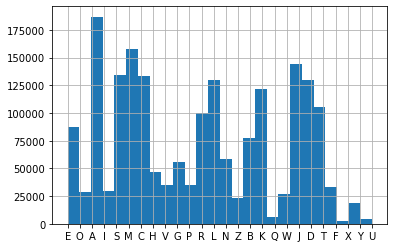

In [197]:
# What are the most common initial letters for names?
names['name'].str[0].hist(bins=26)

In [198]:
names['name'].str[0].unique()

array(['E', 'O', 'A', 'I', 'S', 'M', 'C', 'H', 'V', 'G', 'P', 'R', 'L',
       'N', 'Z', 'B', 'K', 'Q', 'W', 'J', 'D', 'T', 'F', 'X', 'Y', 'U'],
      dtype=object)